In [38]:
#=============================================================================================
#  WHICH CITIES/STATES HAVE UNUSUALLY HIGH CONCENTRATIONS OF DENIAN CLAIMS?
#=============================================================================================

In [5]:
# =============================================================================
# STEP 1: INITIAL EXPLORATORY ANALYSIS - FRAUD BY LOCATION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

# Load data
df = pd.read_csv('Insurance_Project.csv')
print("Total claims: " , (len(df)))

Total claims:  10000


In [20]:
# =============================================================================
# STEP 2: DATA CLEANING AND FILTERING
# =============================================================================
# Replace missing values, remove duplicates, standardize categories

#---------------------------------------
# CHECK MISSING VALUES FIRST
#---------------------------------------
print("Missing values before cleaning:")
print(df[['AGENT_ID', 'CLAIM_AMOUNT']].isnull().sum())

#----------------------------------------
# FILL MISSING NUMERIC VALUES WITH 0
#----------------------------------------
df['CLAIM_AMOUNT'] = df['CLAIM_AMOUNT'].fillna(0)

#---------------------------------------------------
# FILL MISSING CATEGORICAL VALUES WITH 'UNKNOWN'
#---------------------------------------------------
df['AGENT_ID'] = df['AGENT_ID'].fillna('UNKNOWN')

#---------------------------------------------------
# REMOVE DUPLICATES
#---------------------------------------------------
df_clean = df.drop_duplicates()

print("Missing values after cleaning:")
print(df_clean[['AGENT_ID', 'CLAIM_AMOUNT']].isnull().sum())
print("Total claims after cleaning: " , len(df_clean))

Missing values before cleaning:
AGENT_ID        0
CLAIM_AMOUNT    0
dtype: int64
Missing values after cleaning:
AGENT_ID        0
CLAIM_AMOUNT    0
dtype: int64
Total claims after cleaning:  10000


In [22]:
# =============================================================================
# STEP 3: FEATURE ENGINEERING - CREATE SUSPICIOUS PATTERN FLAGS (NO POLICE REPORT)
# =============================================================================

#----------------------------------------
# MASK 1: DENIED CLAIMS
#----------------------------------------
denied_mask = df['CLAIM_STATUS'] == 'D'
df['DENIED_CLAIM'] = 0
df.loc[denied_mask, 'DENIED_CLAIM'] = 1

#----------------------------------------
# MASK 2: HIGH CLAIM AMOUNTS (Above average)
#----------------------------------------
avg_claim_amount = df['CLAIM_AMOUNT'].mean()
high_claim_mask = df['CLAIM_AMOUNT'] > avg_claim_amount
df['HIGH_CLAIM_AMOUNT'] = 0
df.loc[high_claim_mask, 'HIGH_CLAIM_AMOUNT'] = 1

print("SUSPICIOUS PATTERNS CREATED:")
print("when claim amount it is more that the average")
print("Denied claims: " , df['DENIED_CLAIM'].sum())
print("High claim amounts (above $" , round(avg_claim_amount, 2) , "): " , df['HIGH_CLAIM_AMOUNT'].sum())

SUSPICIOUS PATTERNS CREATED:
when claim amount it is more that the average
Denied claims:  503
High claim amounts (above $ 16563.83 ):  3208


In [13]:
# =============================================================================
# STEP 4: STATE-LEVEL ANALYSIS - CALCULATE SUSPICIOUS METRICS
# =============================================================================

print("STATE-LEVEL ANALYSIS:")

#----------------------------------------
# GROUP BY STATE AND CALCULATE KEY METRICS
#----------------------------------------
state_stats = df.groupby('INCIDENT_STATE').agg(
    TOTAL_CLAIMS=('CLAIM_AMOUNT', 'count'),
    DENIED_COUNT=('DENIED_CLAIM', 'sum'),
    HIGH_CLAIM_COUNT=('HIGH_CLAIM_AMOUNT', 'sum'),
    AVG_CLAIM_AMOUNT=('CLAIM_AMOUNT', 'mean')
)

#----------------------------------------
# CALCULATE PERCENTAGES
#----------------------------------------

state_stats['DENIAL_RATE'] = (state_stats['DENIED_COUNT'] / state_stats['TOTAL_CLAIMS']) * 100
state_stats['HIGH_CLAIM_RATE'] = (state_stats['HIGH_CLAIM_COUNT'] / state_stats['TOTAL_CLAIMS']) * 100

print("STATES ANALYZED: " , len(state_stats))
print("\nTOP 5 STATES BY TOTAL CLAIMS:")
print(state_stats.nlargest(5, 'TOTAL_CLAIMS')[['TOTAL_CLAIMS', 'DENIAL_RATE', 'HIGH_CLAIM_RATE']])

STATE-LEVEL ANALYSIS:
STATES ANALYZED:  16

TOP 5 STATES BY TOTAL CLAIMS:
                TOTAL_CLAIMS  DENIAL_RATE  HIGH_CLAIM_RATE
INCIDENT_STATE                                            
CA                      1048     5.438931        30.916031
CO                       707     4.384724        32.107496
FL                       689     4.934688        33.526851
AZ                       637     4.552590        33.751962
CT                       619     4.038772        30.048465


VISUALIZING CLAIM AMOUNT DISTRIBUTION:


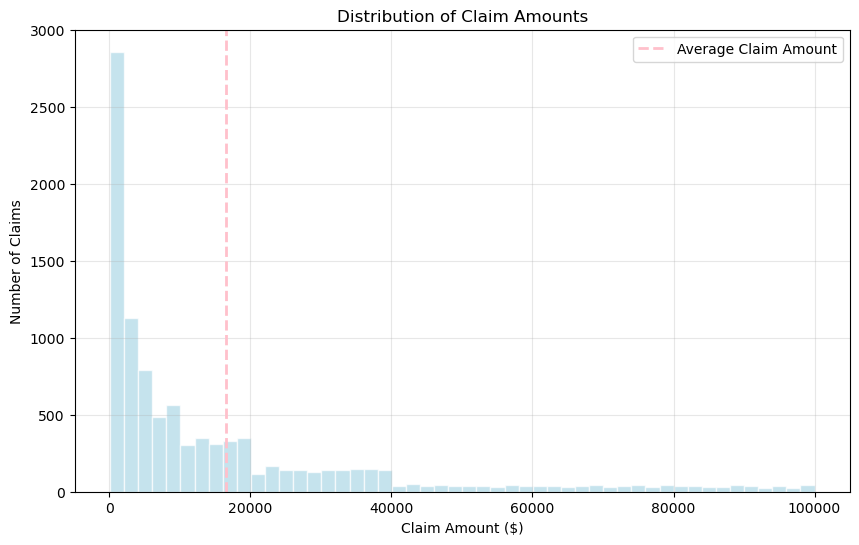

Histogram shows the distribution of all claim amounts
Red line indicates the average claim amount: $ 16563.83


In [14]:
# =============================================================================
# STEP 5: DATA VISUALIZATION - HISTOGRAM OF CLAIM AMOUNTS
# =============================================================================

print("VISUALIZING CLAIM AMOUNT DISTRIBUTION:")

#----------------------------------------
# HISTOGRAM OF CLAIM AMOUNTS
#----------------------------------------
plt.figure(figsize=(10, 6))
plt.hist(df['CLAIM_AMOUNT'], bins=50, color='lightblue', alpha=0.7, edgecolor='white')
plt.axvline(avg_claim_amount, color='pink', linestyle='--', linewidth=2, label='Average Claim Amount')
plt.xlabel('Claim Amount ($)')
plt.ylabel('Number of Claims')
plt.title('Distribution of Claim Amounts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Histogram shows the distribution of all claim amounts")
print("Red line indicates the average claim amount: $", round(avg_claim_amount, 2))

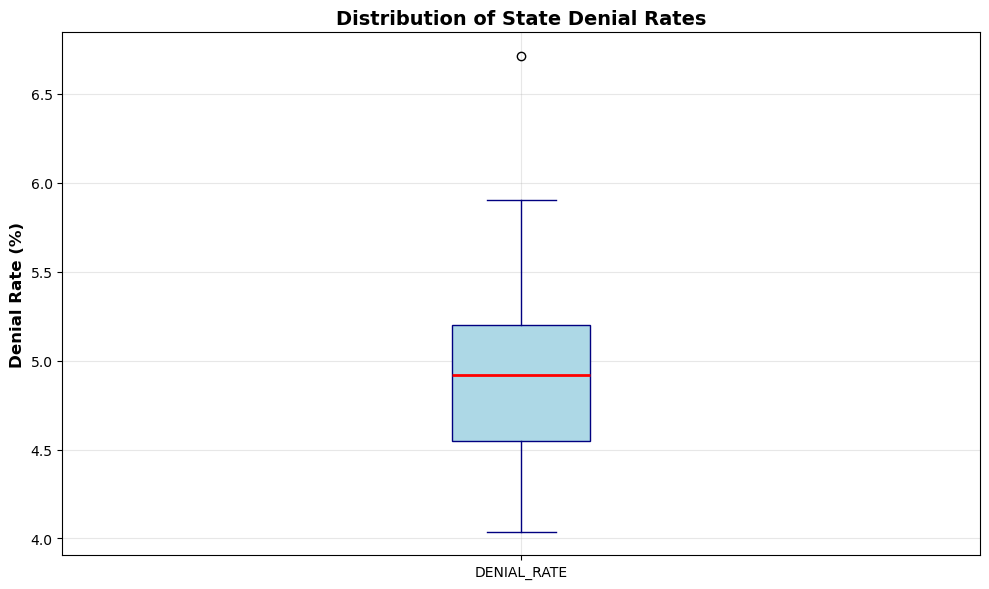

In [30]:
# =============================================================================
# OUTLIER DETECTION FOR HIGH-RISK STATES - VISUALIZATION 1
# =============================================================================

# Box plot for denial rates
plt.figure(figsize=(10, 6))
state_stats['DENIAL_RATE'].plot(kind='box', color='royalblue', patch_artist=True, 
                               boxprops=dict(facecolor='lightblue', color='navy'),
                               medianprops=dict(color='red', linewidth=2),
                               whiskerprops=dict(color='navy'),
                               capprops=dict(color='navy'))
plt.title('Distribution of State Denial Rates', fontsize=14, fontweight='bold')
plt.ylabel('Denial Rate (%)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

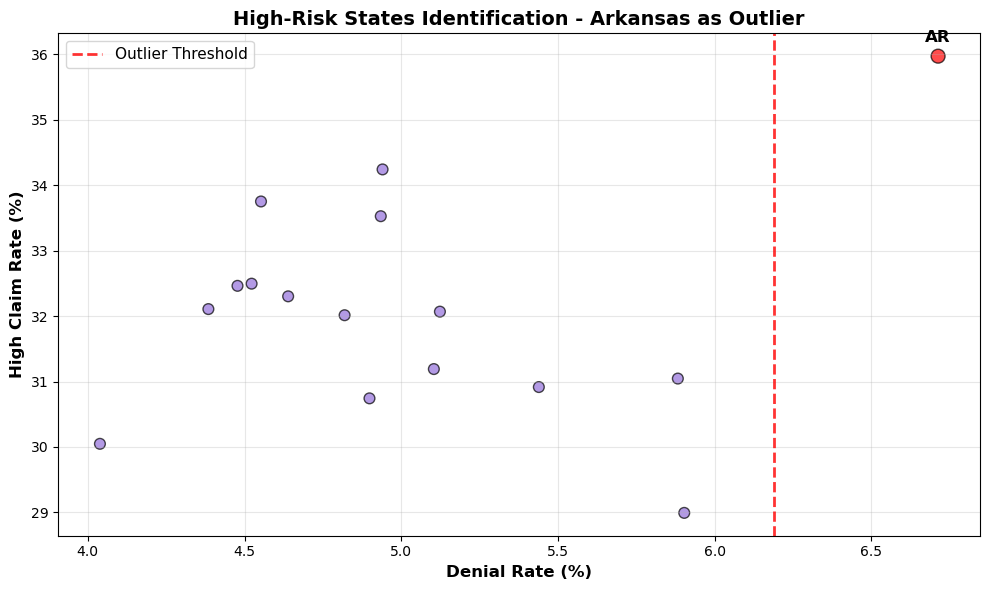

In [28]:
# =============================================================================
# OUTLIER DETECTION FOR HIGH-RISK STATES - VISUALIZATION 2
# =============================================================================

# Highlight outliers in scatter plot
plt.figure(figsize=(10, 6))
colors = ['red' if x > upper_threshold else 'mediumpurple' for x in state_stats['DENIAL_RATE']]
sizes = [100 if x > upper_threshold else 60 for x in state_stats['DENIAL_RATE']]

plt.scatter(state_stats['DENIAL_RATE'], state_stats['HIGH_CLAIM_RATE'], 
           c=colors, alpha=0.7, s=sizes, edgecolors='black', linewidth=1)

# Add state labels for outliers
for state, row in state_stats.iterrows():
    if row['DENIAL_RATE'] > upper_threshold:
        plt.annotate(state, (row['DENIAL_RATE'], row['HIGH_CLAIM_RATE']), 
                    textcoords="offset points", xytext=(0,10), ha='center', 
                    fontweight='bold', fontsize=12)

plt.axvline(upper_threshold, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Outlier Threshold')
plt.xlabel('Denial Rate (%)', fontsize=12, fontweight='bold')
plt.ylabel('High Claim Rate (%)', fontsize=12, fontweight='bold')
plt.title('High-Risk States Identification - Arkansas as Outlier', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
#=============================================================================================
#AR : 6.713 % denial rate, 35.972 % high claims can be a posible candiate for insurance fraud
#=============================================================================================